# Introduction 

# Software Imports and Plot Settings 

In [1]:
# then third party libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# jupyter notebook extras
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# set plotting parameters
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

# Data Inputs

## Import Load and Generation Data

In [3]:
model = pd.read_pickle('solar-and-load.pkl')

# Model Inputs

In [4]:
tier_1_percent = 0.0284
look_ahead_interval = 96


battery_power = 355
battery_capacity = 710  # kwh
intervals_per_hour = 4
pv_to_grid_export_threshold = battery_power / (intervals_per_hour * 2)
battery_max_export_15min = battery_power / intervals_per_hour

# Resilience Calculations

## Old Complicated Logic
**Idea:** This calculation is unnecessarily complicated. What it effectively does is that it looks ahead in the next 24 hours, and adds all Tier 1 loads between 9pm and the time in the morning when the sun starts shining, and calls this the SOCr. The basic idea here is that any load that any load in the next 24 hours not met by the pv generation in that interval should be added to the SOCr. However, the 9pm cutoff actually interferes with even this basic calculation. Also, this calculation does not account for the fact that the battery can be charged after grid disconnect. <br><br>

## Simplified Logic
**Idea:** The thought behind this calculation is to look at each interval in the next day (the `look_ahead_period`). If the solar generation does not cover the total tier 1 load during this period, we add that load to the SOCr value. This calculation does not account for the fact that the battery can be charged after grid disconnect.<br><br>
**Logic (Pseudo code):** 
```
At given Interval:
SOCr = 0

For each interval in look ahead period:

    If (PV generation < Tier 1 Load):
    
        Add Tier 1 Load to SOCr
```

In [5]:
def is_battery_reserve_needed(row):
    return row['pv_generation'] < row['load'] * tier_1_percent

model['is_battery_needed'] = model.apply(lambda row : is_battery_reserve_needed(row), axis=1)

model['old_socr'] = (
    (model['load'] * model['is_battery_needed'])
    .iloc[::-1].rolling(look_ahead_interval, min_periods=1)
    .sum().iloc[::-1] * tier_1_percent)

## New SOCr

**Idea:** For the interval we are calculating at, assume grid disconnection happens at that interval. We need to account for how the battery gets charged after grid disconnection. <br>
For each interval in the next day (the `look_ahead_period`) we first see whether the battery has charged enough (after disconnection) to power the critical Tier 1 load. If not, we add the load to the SOCr value. We then add PV generation in that interval to the battery charge (after disconnection).
<br><br>
**Logic (Pseudo code):** 
```
At given Interval:
SOCr = 0
battery charge after disconnect = 0

For each interval in look ahead period:

    If (battery charge after disconnect > Tier 1 Load):
    
        subtract tier 1 load from battery charge
    
    Else (battery charge after disconnect <= Tier 1 Load):
    
        Add Tier 1 load - remaining battery to SOCr
        Reset battery charge after disconnect to 0
        
    Add PV generation in interval to battery charge after disconnect
    
```

In [6]:
def calculate_socr():

    load = model['load'].to_numpy()
    pv = model['pv_generation'].to_numpy()
    socr = np.zeros(len(model))

    for i in range(len(load)):
        battery = 0
        reserve_needed = 0

        for j in range(i, min(i + look_ahead_interval, len(load))):

            tier_1_load = load[j] * tier_1_percent

            if (battery > tier_1_load):
                battery -= tier_1_load

            else:
                reserve_needed = min(reserve_needed + tier_1_load - battery, battery_capacity)
                battery = 0

            battery = min((pv[j] + battery), battery_capacity)

        socr[i] = reserve_needed
        
    return socr

model['new_socr'] = calculate_socr()

# Plot SOCr
Set the date range below

In [7]:
start_date = '2019-01-30'
end_date = '2019-02-05'

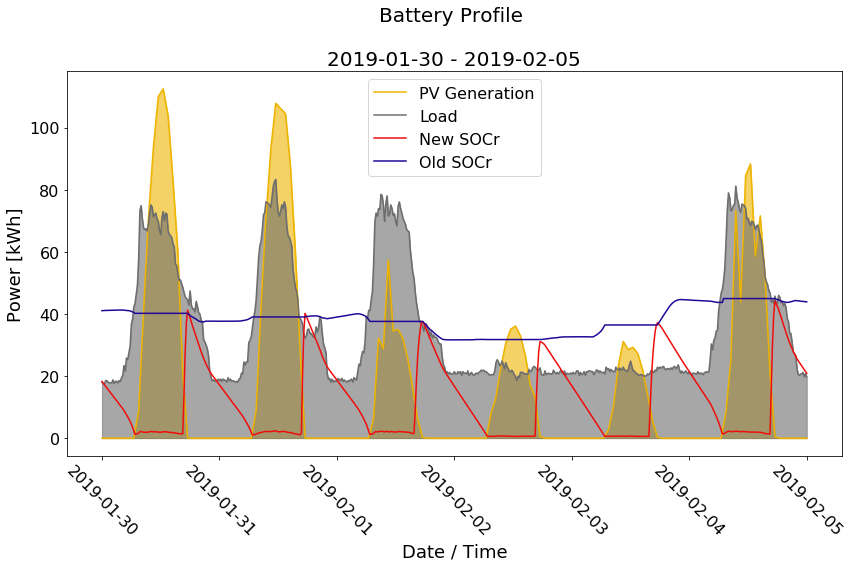

In [8]:
df = model[(model['datetime'] >= start_date) & (model['datetime'] <= end_date)]

plt.figure()

plt.plot(df['datetime'], df['pv_generation'], color='#eeb400', label='PV Generation')
#plt.axhline(battery_capacity, color='black', label='Battery Capacity')
plt.fill_between(df['datetime'], df['pv_generation'], color='#eeb400', alpha = 0.6)
plt.plot(df['datetime'], df['load'], color='#6d6d6d', label='Load')
plt.fill_between(df['datetime'],df['load'], color='#6d6d6d', alpha = 0.6)
plt.plot(df['datetime'], df['new_socr'], color='#f20b0b', label='New SOCr')
plt.plot(df['datetime'], df['old_socr'], color='#220597', label='Old SOCr')
plt.title(f'Battery Profile \n\n{start_date} - {end_date}')
plt.xlabel('Date / Time')
plt.xticks(rotation='315')
plt.ylabel('Power [kWh]')
plt.legend()
plt.tight_layout()
#plt.savefig('new_socr.png')